In [1]:
%matplotlib inline

import importlib.util
import scipy.misc
import time
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

#Import the vizdoom package since it can't be installed normally on Windows

vizdoom = importlib.util.spec_from_file_location('vizdoom',
                                                 'C:/Anaconda3/envs/doom/Lib/site-packages/vizdoom/vizdoom.pyd')
vd = importlib.util.module_from_spec(vizdoom)
vizdoom.loader.exec_module(vd)


In [35]:
#Downsample and normalize an image array representing the game state at a given time stamp

def preprocess(image, down_sample_ratio=1):
    if down_sample_ratio != 1:
        image = scipy.misc.imresize(image, down_sample_ratio)
    image = image.astype(np.float32)
    image /= 255.0
    
    return image
    

In [65]:
#Specify the available actions in the scenario and the parameters

shoot = [0, 0, 1]
left = [1, 0, 0]
right = [0, 1, 0]
actions = [left, right, shoot]

episodes = 1
experience = list()
t = 0
pretrain_steps = 10000

#Specify the scenario and screen format/resolution

game = vd.DoomGame()
game.set_screen_format(vd.ScreenFormat.BGR24)
game.set_screen_resolution(vd.ScreenResolution.RES_160X120)
game.load_config('basic.cfg')


True

In [71]:
width = game.get_screen_width()
height = game.get_screen_height()
channels = game.get_screen_channels()

s_t = tf.placeholder(tf.float32, shape=[None, height, width, channels], name='state')
a_t = tf.placeholder(tf.int32, shape=[None, len(actions)], name='action')

input_layer = tf.reshape(s_t, [-1, height, width, channels], name='input_layer')
conv1 = tf.layers.conv2d(inputs=input_layer,
                         filters=32,
                         kernel_size=[7, 7],
                         padding='valid',
                         activation=tf.nn.relu,
                         name='conv1_layer')

conv1_norm = tf.layers.batch_normalization(inputs=conv1,
                                           name='conv1_batch_norm')
conv2 = tf.layers.conv2d(inputs=conv1,
                         filters=64,
                         kernel_size=[4, 4],
                         padding='valid',
                         activation=tf.nn.relu,
                         name='conv2_layer')
conv2_norm = tf.layers.batch_normalization(inputs=conv2,
                                           name='conv2_batch_norm')

flatten = tf.reshape(conv2_norm, [-1, height*width*channels], name='flatten')
dense1 = tf.layers.dense(inputs=flatten,
                         units=512,
                         activation=tf.nn.relu,
                         name='dense1_layer')
dense1_norm = tf.layers.batch_normalization(inputs=dense1,
                                            name='dense1_batch_norm')


In [61]:
#For each time step, collect the following data:
#The current game state
#The action that was taken taken
#The reward obtained from the chosen action
#The next game state (if the episode hasn't ended yet)
#A variable indicating whether the episode is over yet

game.init()

for i in range(episodes):
#while t < pretrain_steps:
    game.new_episode()

    while not game.is_episode_finished():
        state = game.get_state()
        state1 = preprocess(state.screen_buffer, 0.5)
        action = np.random.randint(3)
        reward = game.make_action(actions[action])
        done = game.is_episode_finished()

        if done == False:
            state = game.get_state()
            state2 = preprocess(state.screen_buffer, 0.5)
        
        elif done == True:
            state2 = None
        
        experience.append((state1, action, reward, state2, done))
        t += 1
        time.sleep(0.02)    
    
    print("Result:", game.get_total_reward())
    print("Current Time Step:", t)
    time.sleep(2)

print(len(experience))
print(t)
game.close()


Result: -49.0
Current Time Step: 120
120
120


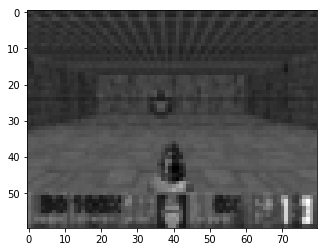

In [64]:
plt.imshow(experience[2][0])

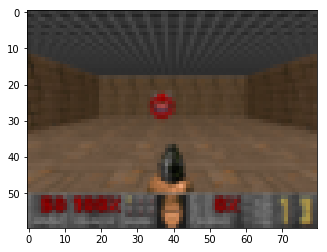

In [21]:
plt.imshow(scipy.misc.imresize(experience[2][0], (game.get_screen_height()//8, game.get_screen_width()//8)))

In [46]:
state.screen_buffer[::2, ::2, :].shape

(60, 80, 3)

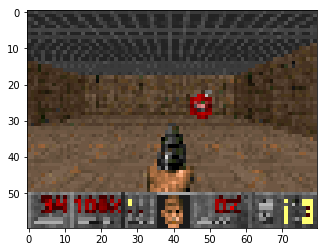

In [55]:
plt.imshow(state.screen_buffer[::2, ::2, :])